# Тестовое задание Авито

## Оглавление:

* [Постановка задачи](#target_setting)
* [Подключение библиотек](#load_libs)
* [Пути к директориям и файлам](#path_data)
* [Используемые константы](#used_constants)
* [Используемые функции](#used_functions)
* [Загрузка исходных данных](#load_data)           
* [Анализ данных (Exploratory Data Analysis (EDA))](#eda)
    * [Обзор данных](#data_overview)
    * [Обзор уникальных значений в признаках](#unique_data)
    * [Обзор целевой переменной](#target_feature_overview)
    * [Обзор признаков](#feature_overview)
    * [Распределение целевой переменной по признакам](#target_distribution)
    * [Определение длины сообщения и % знаков препинания в тексте описания (description)](#len_punct)   
* [Предварительная обработка данных](#data_preprocessing)
    * [Поиск регулярных выражений в описании](#regexp_search)
    * [Очиcтка текста приведение слов к стандартному виду](#text_clearing) 
* [Построение модели CatBoost](#modeling)    
    * [Построение финальной модели](#final_model)
    * [Сохранение финальной модели](#final_model_saving)
    * [Сохранение результатов](#saving_results) 

## Постановка задачи<a class="anchor" id="target_setting"></a>

**<u>Задание<u>**

Определить есть ли в объявлении контактная информация.

В первой задаче необходимо оценить вероятность наличия в объявлении контактной информации. 

Таргет первой задачи: __is_bad__.

Есть два датасета: __train.csv__ и __val.csv__. В датасетах могут встречаться (как и, к сожалению, в любых размечаемых данных) некорректные метки.

__train.csv__ содержит больше данных, однако разметка в нём менее точная.

В __val.csv__ существенно меньше данных, но более точная разметка.

Тестовый датасет, на котором мы оценим решение, будет больше похож на __val.csv__.

__val.csv__ находится в папке __./data__. __train.csv__ можно качать скриптом __./data/get_train_data.sh__ или перейдя по ссылке

<br>
    
**<u>Критерии оценки<u>**

В качестве метрики качества работы вашей модели мы будем использовать усредненный ROC-AUC по каждой категории объявлений.  
Текущий бэйзлайн, который надо побить для первой части - 0.92.

<br>
    
**<u>Требования к решению<u>**

Результатом работы модели является __pd.DataFrame__ с колонками:

* __index__: __int__, положение записи в файле;
* __prediction__: __float__ от 0 до 1.


## Подключение библиотек<a class="anchor" id="load_libs"></a>

In [1]:
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost
# !pip install imbalanced-learn
# !pip install wordcloud
# !pip install pymorphy2
# !pip install pyaspeller
# !pip install tensorflow-gpu
# !pip install pandarallel
# pip install --upgrade pandas
# !pip install catboost
# !pip install ipywidgets
# !pip install --upgrade jupyter_core jupyter_client
# !jupyter nbextension enable --py widgetsnbextension
# !pip install emoji

In [2]:
# Libraries for working with paths and saving
from pathlib import Path
import os
import pickle
from json import load as json_load

# Scientific libraries
import numpy as np
from numpy import zeros
import pandas as pd
np.set_printoptions(precision=4)
from pandas import read_csv
import re

# Visual libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})
plt.style.use('seaborn')

# Scikit-learn libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from functools import partial, lru_cache
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

# CatBoost
import catboost
from catboost import *
from catboost import datasets
from catboost import CatBoostClassifier, Pool
from catboost import cv

# # Language libraries
import pymorphy2
import nltk
from nltk.corpus import stopwords
import string
from tabulate import tabulate

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
# print(f'Версия xgboost: {xgb.__version__}')
# !python --version
# print(pd.__version__)

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Пути к директориям и файлам<a class="anchor" id="path_data"></a>

In [5]:
DATA_ROOT = Path('../')
MODELS_PATH = Path('../2_models/')

# input
STOPWORDS_PATH = DATA_ROOT / '3_work/stopwords.json'
TRAIN_DATASET_PATH = DATA_ROOT / '1_data/train.csv'
TEST_DATASET_PATH = DATA_ROOT / '1_data/val.csv'
DICT_PATH = DATA_ROOT / '3_work/regexp_dict.json'


# output
PREP_TRAIN_DATASET_PATH = DATA_ROOT / '3_work/df_train_prepared_full_cat.csv'
# PREP_TEST_DATASET_PATH = DATA_ROOT / '3_work/df_test_prepared.csv'
SUBMISSION_PATH = DATA_ROOT / '4_predictions/task1_prediction_full.csv'

MODEL_FILE_PATH = MODELS_PATH / 'final_model_full_cat.cbm'

## Используемые константы<a class="anchor" id="used_constants"></a>

In [6]:
# Список используемых переменных констант

RANDOM = 42
MORPH = pymorphy2.MorphAnalyzer()

## Используемые функции<a class="anchor" id="used_functions"></a>

In [7]:
# загрузка словаря "стоп-слов"
with open(STOPWORDS_PATH) as json_file:
    additional_stopwords = json_load(json_file)
    json_file.close()
    
my_stopwords = set(stopwords.words('russian'))
my_stopwords.update(additional_stopwords)
my_stopwords.update(stopwords.words('english'))

In [8]:
# очистка текста
def get_text_clearing(text):
    reg = re.compile('[^0-9a-zA-Zа-яА-ЯёЁ\.,\(\)]+]')    
    
    text = re.sub(r'([^\w ])', r' \1', text)
    text = re.sub(r'([^ \w])', r'\1', text)
    text = re.sub(r' +', r' ', text)
    text = re.sub(r'^ ', r'', text)
    text = re.sub(r'[\W_]+', ' ', text)  
    text = reg.sub(' ', text)
    # удаляем лишние пробелы
    text = ' '.join(text.split())
    # приводим к нижнему регистру
    text = text.lower()
    return text

# Лемматизация  
@lru_cache(maxsize=100000)
def get_lemmatization(word, MORPH):
    return MORPH.parse(word)[0].normal_form  

# функция предварительной обработки, включая очистку, удаление стоп-слов и лемматизацию
def get_text_preprocessing(text):
    text = get_text_clearing(str(text)).split()
    text = [word for word in text if word not in my_stopwords]
    return ' '.join(map(lambda word: get_lemmatization(word, MORPH), text))

In [9]:
# функция поиска по словарю

def get_dict_search(sample, text):
    events = []
    for name, regexp in sample.items():
        events.append(int(bool(re.search(regexp, text))))
    return events    

In [10]:
def category_metrics_getter(X, y, category, pred_probas, labels_pred, cats_table, model):
    cat_name = category.lower().replace(" ", "_")
        
    pred_probas[X["category"] == category] = model.predict_proba(X.drop(['category'], axis=1)[X["category"] == category])[:, 1]
    labels_pred[X["category"] == category] = model.predict(X.drop(['category'], axis=1)[X["category"] == category])
    
    rocauc_category = roc_auc_score(y[X["category"] == category], pred_probas[X["category"] == category])
    f1_category = f1_score(y[X["category"] == category], labels_pred[X["category"] == category])
    accuracy_category = accuracy_score(y[X["category"] == category], labels_pred[X["category"] == category])
    
    cats_table.append([cat_name, rocauc_category, f1_category, accuracy_category])
    return pred_probas, labels_pred, cats_table

def metrics_printer(X, y, model):
    overall_table = []
    cats_table = []
    pred_probas = zeros(y.shape)
    labels_pred = zeros(y.shape)
    for category in X["category"].unique():
        pred_probas, labels_pred, cats_table = category_metrics_getter(
            X, y, category, pred_probas, labels_pred, cats_table, model,
        )
    rocauc = roc_auc_score(y, pred_probas)
    f1 = f1_score(y, labels_pred)
    accuracy = accuracy_score(y, labels_pred)
    overall_table.append([rocauc, f1, accuracy])
    print("Таблица по категориям:")
    print(tabulate(cats_table, headers=["Category", "AUC", 'f1', 'accuracy'], tablefmt='orgtbl') + '\n')
    print("Общая таблица:")
    print(tabulate(overall_table, headers=['AUC', 'f1', 'accuracy'], tablefmt='orgtbl'))

## Загрузка исходных данных<a class="anchor" id="load_data"></a>

**Описание базового датасета**

Для обучения и инференса обоих задач у вас есть следующие поля:

* __title__ - заголовок,
* __description__ - описание,
* __subcategory__ - подкатегория,
* __category__ - категория,
* __price__ - цена,
* __region__ - регион,
* __city__ - город,
* __datetime_submitted__ - дата размещения.


In [11]:
%%time

df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

CPU times: user 13.2 s, sys: 775 ms, total: 14 s
Wall time: 15.8 s


,title,description,subcategory,category,price,region,city,datetime_submitted,is_bad
0,Диван-кровать,Продаем диван-кровать. Удобный механизм - евро...,Мебель и интерьер,Для дома и дачи,7000.0,Россия,Москва,2019-06-01 00:00:15.180656,0
1,Кожух рулевой колонки Даф хф 91 4509834,Кожух рулевой колонки DAF XF 94 (60066004)/\n ...,Запчасти и аксессуары,Транспорт,2290.0,Россия,Москва,2019-06-01 00:00:44.317933,0
2,Дешёвый буст аккаунтов Dota 4,! Буст аккаунтов с ммр выше 1000ммр не беру ! ...,Предложение услуг,Услуги,200.0,Северная Осетия,Владикавказ,2019-06-01 00:00:50.249692,1
3,Телевизор sharp.Смарт тв.Интернет,Продам телевизор . Диагональ 450.наличие входа...,Аудио и видео,Бытовая электроника,25000.0,Калининградская область,Советск,2019-06-01 00:00:50.325799,1
4,Открытка-конверт,Открытки-конверты ручной работы/\nВыполнены в ...,Коллекционирование,Хобби и отдых,150.0,Ставропольский край,Ессентукская,2019-06-01 00:00:56.632655,0


__Примечание:__  
Изначально второй датасет назывался валидационный (val.csv). Но, для простаты восприятия переименнуем его в тестовый.  

In [12]:
%%time

df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

CPU times: user 298 ms, sys: 16.2 ms, total: 314 ms
Wall time: 352 ms


,title,description,subcategory,category,price,region,city,datetime_submitted,is_bad
0,Шины,Звонить 89425546881,Запчасти и аксессуары,Транспорт,2000.0,Тульская область,Огаревка,2019-10-10 00:00:25.200714,1
1,Продается мобильная перегородка с дверью,"Мобильная перегородка, предназначена для разгр...",Оборудование для бизнеса,Для бизнеса,10500.0,Вологодская область,Вологда,2019-10-10 00:03:11.527292,0
2,Комплект зимних шин на дисках 682/32/64,Шины зимние б/у Marshal Assimetric I”Zen KW 61...,Запчасти и аксессуары,Транспорт,4000.0,Россия,Москва,2019-10-10 00:05:07.193248,1
3,Кровать-трансормер Дакота сб-4085,"Продаю кровать-трансформер производства ""Столп...",Мебель и интерьер,Для дома и дачи,17000.0,Московская область,Химки,2019-10-10 00:05:58.165179,0
4,Honda VFR 800 2004 г.в,"Мот в отличном состоянии для своих лет, Родной...",Мотоциклы и мототехника,Транспорт,235000.0,Брянская область,Брянск,2019-10-10 00:06:19.231151,0


In [13]:
print('Тренировочный датасет df_train:', df_train.shape)
print('Тестовый датасет df_test:', df_test.shape)

Тренировочный датасет df_train: (984487, 9)
Тестовый датасет df_test: (16237, 9)


__Примечание:__  
Объединяем df_train и df_test

In [14]:
df_train = pd.concat([df_train, df_test], axis=0, ignore_index=True)

In [15]:
print('Объединенный датасет df_train:', df_train.shape)

Объединенный датасет df_train: (1000724, 9)


## Анализ данных (Exploratory Data Analysis (EDA))<a class="anchor" id="eda"></a>

### Обзор данных<a class="anchor" id="data_overview"></a>

In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000724 entries, 0 to 1000723
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   title               1000724 non-null  object 
 1   description         1000724 non-null  object 
 2   subcategory         1000724 non-null  object 
 3   category            1000724 non-null  object 
 4   price               941813 non-null   float64
 5   region              1000724 non-null  object 
 6   city                1000724 non-null  object 
 7   datetime_submitted  1000724 non-null  object 
 8   is_bad              1000724 non-null  int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 68.7+ MB


 Посмотрим на NaN'ы:

In [17]:
df_train['price'].isna().value_counts()

False    941813
True      58911
Name: price, dtype: int64

In [18]:
df_train[df_train.isnull().any(1)]

,title,description,subcategory,category,price,region,city,datetime_submitted,is_bad
22,Монтаж отопления гвс. хвс. установка сантехники,Несколько вариантов разводки системы отопления...,Предложение услуг,Услуги,NaN,Смоленская область,Вязьма,2019-06-01 00:06:52.358883,0
47,Обучение.Удостоворение.Электробезопасность.охрана,5. Аттестация сотрудников: рабочего пер...,Предложение услуг,Услуги,NaN,Россия,Москва,2019-06-01 00:13:49.892272,0
113,Автомобиль в разборе: Citroen Berlingo 2002-2008,В наличии Автомобиль в разборе:/\n/\nCitroen B...,Запчасти и аксессуары,Транспорт,NaN,Россия,Москва,2019-06-01 00:39:31.479077,0
125,Квартира в рассрочку,Есть возможность приобретения квартиры на терр...,Предложение услуг,Услуги,NaN,Магаданская область,Магадан,2019-06-01 00:44:13.808647,1
129,Колёса,"Продуется колеса с дисками штампованными , плю...",Запчасти и аксессуары,Транспорт,NaN,Чеченская Республика,Грозный,2019-06-01 00:45:39.741722,1
...,...,...,...,...,...,...,...,...,...
1000616,Самовар угольный Тулпромторг обьём 3 л,Коллекционный угольный самовар Тулпромторг/\nТ...,Коллекционирование,Хобби и отдых,NaN,Россия,Москва,2019-10-14 22:32:33.468887,0
1000632,Отдам в добрые руки,"Отдам даром метиса таксы,4 месяца все вопросы ...",Собаки,Животные,NaN,Калужская область,Кондрово,2019-10-14 22:45:29.454668,1
1000654,2d печать металлом и широкоформатная 2d печать,"Широкоформатная 4d печать 3900х3000х700, 4d пе...",Предложение услуг,Услуги,NaN,Россия,Санкт-Петербург,2019-10-14 23:02:33.001932,0
1000657,"Офисный, персональный водитель","Спокоен, уравновешен, не раздражителен, вежлив...",Резюме,Работа,NaN,Россия,Москва,2019-10-14 23:03:31.889193,1


In [19]:
df_train.iloc[984404]

title                               Малыши из подвала очень хотят домой
description           ❗❗❗СРОЧНО❗❗❗МАЛЫШИ ИЗ ПОДВАЛА ИЩУТ ДОМ❗/\n(пос...
subcategory                                                      Собаки
category                                                       Животные
price                                                               NaN
region                                          Калининградская область
city                                                        Калининград
datetime_submitted                           2019-10-09 23:14:49.807021
is_bad                                                                1
Name: 984404, dtype: object

In [20]:
s = df_train.iloc[984404]['description']
s1 = get_text_clearing(s)
print(s, ' ', s1, sep='\n')

❗❗❗СРОЧНО❗❗❗МАЛЫШИ ИЗ ПОДВАЛА ИЩУТ ДОМ❗/
(пост по ним https://vk.com/wall407411512_3075)/
/
Замечательные малыши (возраст примерно месяца 3,5-6) родились в подвале.. мы их перенесли в другой уголок, но долго они там не смогут находиться, им срочно нужен хозяин!!! /
/
🌸Будут среднего размера. (видели мать, она по колено) Обработали щенуль от глистов. /
🌸 Испуганные, а глаза полные надежды и в то же время такой глубокой грусти... Приютите малыша, любой их них не забудет вашего добра и будет верным другом./
/
🌸Возможна доставка.
 
срочно малыши из подвала ищут дом пост по ним https vk com wall407411512 3075 замечательные малыши возраст примерно месяца 3 5 6 родились в подвале мы их перенесли в другой уголок но долго они там не смогут находиться им срочно нужен хозяин будут среднего размера видели мать она по колено обработали щенуль от глистов испуганные а глаза полные надежды и в то же время такой глубокой грусти приютите малыша любой их них не забудет вашего добра и будет верным другом 

In [21]:
is_nan = df_train.isna().sum() / len(df_train) * 100
print('Количество значений "NaN" в тренеровочном датасете (%):')
print(is_nan[is_nan > 0].sort_values(ascending=False))

Количество значений "NaN" в тренеровочном датасете (%):
price    5.886838
dtype: float64


**Вывод:** Пропуски в df_train есть в признаке 'price'. 58048 штук или 5,9%. <br>
В прочих случаях, при таком проценте, можно строки удалять. Попробуем оставить и заменить на 0 или среднее значение.

Обзор уникальных значений в признаках

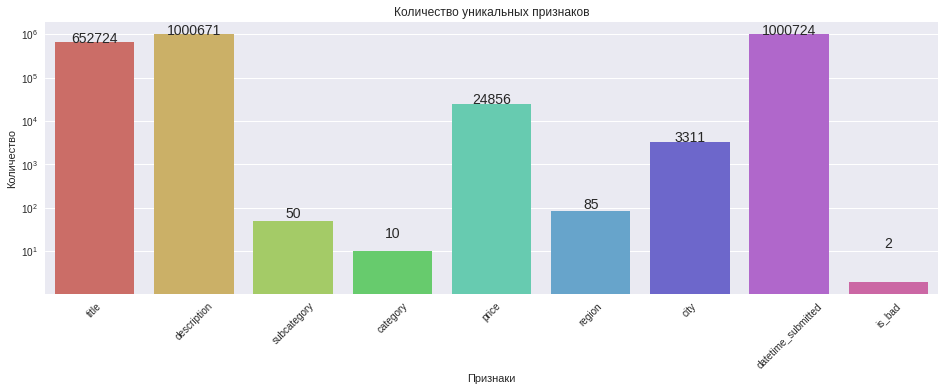

In [22]:
plt.figure(figsize=(16, 5))

cols = df_train.columns
uniques = [len(df_train[col].unique()) for col in cols]

ax = sns.barplot(x=cols, y=uniques, palette='hls', log=True)
ax.set(xlabel='Признаки', ylabel='Количество', title='Количество уникальных признаков')


for p, uniq in zip(ax.patches, uniques):
    ax.text(p.get_x() + p.get_width()/2.,
            uniq + 10,
            uniq,
            ha="center") 

ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

**Вывод:**  
Train.csv  
Состоит из 984487 строк и 9 столбцов. 7 признаков имеют тип данных object, и по одному float64 и int64(целевая переменная «is_bad»). В столбце «price» имеются 58048 пропусков NaN, что составляет 5,9%.  
Test.csv  
Состоит из 16237 строк и 9 столбцов. 7 признаков имеют тип данных object, и по одному float64 и int64(целевая переменная «is_bad»). В столбце «price» имеются 863 пропусков NaN, что составляет 5,3%.

### Обзор целевой переменной<a class="anchor" id="target_feature_overview"></a>

__is_bad__ - метка, характеризующая наличие в объявлении контактной информации.  
Имеет значения:  
0 – контактная информация отсутствует;  
1 – есть контактная информация

In [23]:
df_train['is_bad'].value_counts()

0    758477
1    242247
Name: is_bad, dtype: int64

In [24]:
is_0 = len(df_train[df_train['is_bad'] == 0])
is_1 = len(df_train[df_train['is_bad'] == 1])

In [25]:
is_0_percent = is_0 / len(df_train) * 100
is_1_percent = is_1 / len(df_train) * 100
print(f'Количество значений "0" в тестовом датасете: {is_0_percent:.3f} %')
print(f'Количество значений "1" в тестовом датасете: {is_1_percent:.3f} %')

Количество значений "0" в тестовом датасете: 75.793 %
Количество значений "1" в тестовом датасете: 24.207 %


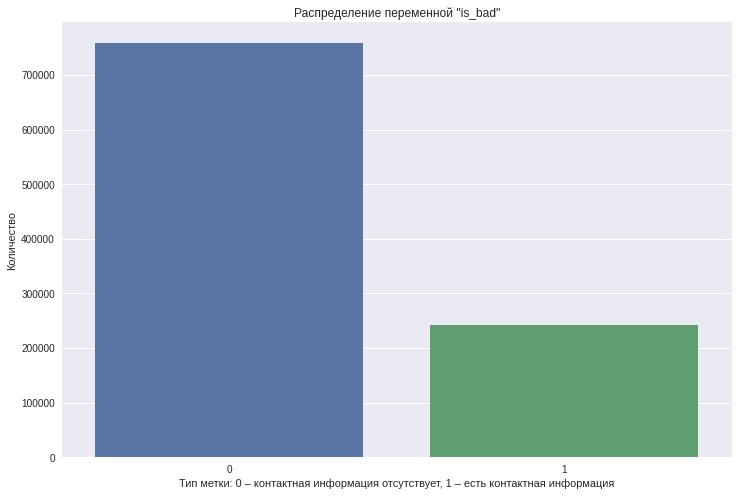

In [26]:
counts = df_train['is_bad']. value_counts()

plt.figure(figsize=(12,8))
plt.title('Распределение переменной "is_bad"')
sns.barplot(counts.index, counts.values)
plt.xlabel('Тип метки: 0 – контактная информация отсутствует, 1 – есть контактная информация')
plt.ylabel('Количество')
plt.show()

**Вывод:**  <br> 
В тренеровочном датасете (df_train) целевая переменная __is_bad__ имеет перевес примерно в 3 раза по значению 0: 75,798% против 24.202%. <br> 
Пропуски и выбросы отсутствуют.

### Обзор признаков<a class="anchor" id="feature_overview"></a>

#### __Заголовок__

In [27]:
df_train['title'].value_counts()

Платье                                               5198
Диван                                                2803
Велосипед                                            2602
iPhone 7                                             2478
Коляска                                              2253
                                                     ... 
Кожаный руль с кнопками магнитолы Chevrolet Cruze       1
Слинги для малыша                                       1
Продам срез натуральных славянских волос                1
Литература в таблицах и схемах (Мещерякова М.)          1
BMW 7 серия, 1031                                       1
Name: title, Length: 652724, dtype: int64

In [28]:
data = df_train['title'].value_counts().iloc[:10]
data

Платье         5198
Диван          2803
Велосипед      2602
iPhone 7       2478
Коляска        2253
Комбинезон     2061
Куртка         1857
Туфли          1812
Холодильник    1806
Кровать        1704
Name: title, dtype: int64

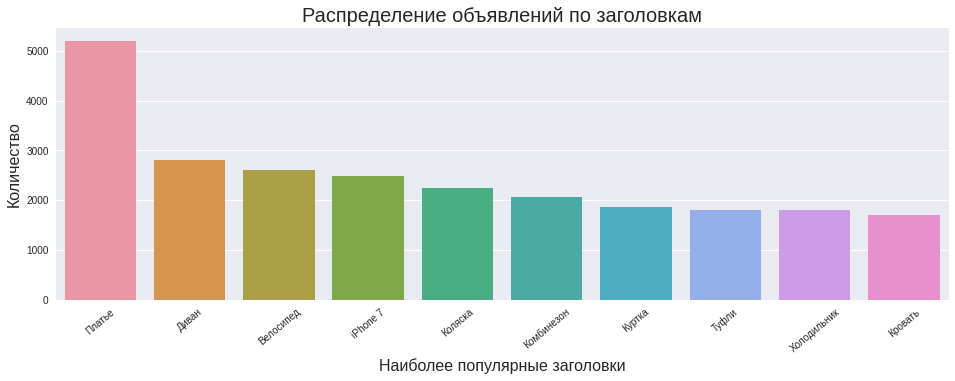

In [29]:
plt.figure(figsize=(16,5))

ax = sns.barplot(x=data.index, y=data.values)
ax.set_xlabel('Наиболее популярные заголовки', fontsize=16)
ax.set_ylabel('Количество', fontsize=16)
ax.set_title('Распределение объявлений по заголовкам', fontsize=20)
plt.xticks(rotation=40);

#### __Регион и город__

In [30]:
df_train.groupby(['region', 'city']).count()['is_bad']

region               city       
Адыгея               Абадзехская      38
                     Адыгейск         35
                     Белое             8
                     Блечепсин        10
                     Вольное           7
                                    ... 
Ярославская область  Семибратово      14
                     Туношна          26
                     Тутаев          155
                     Углич           172
                     Ярославль      6901
Name: is_bad, Length: 3545, dtype: int64

#### __Регион__

In [31]:
df_train['region'].value_counts()

Россия                  241999
Краснодарский край       53994
Московская область       50959
Татарстан                34215
Свердловская область     28363
                         ...  
Магаданская область        505
Тыва                       194
Сахалинская область        170
Ненецкий АО                 60
Чукотский АО                27
Name: region, Length: 85, dtype: int64

In [32]:
data = df_train['region'].value_counts().iloc[0:10]
data

Россия                   241999
Краснодарский край        53994
Московская область        50959
Татарстан                 34215
Свердловская область      28363
Ростовская область        28001
Нижегородская область     24255
Башкортостан              24247
Челябинская область       23944
Самарская область         23855
Name: region, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Россия'),
  Text(1, 0, 'Краснодарский край'),
  Text(2, 0, 'Московская область'),
  Text(3, 0, 'Татарстан'),
  Text(4, 0, 'Свердловская область'),
  Text(5, 0, 'Ростовская область'),
  Text(6, 0, 'Нижегородская область'),
  Text(7, 0, 'Башкортостан'),
  Text(8, 0, 'Челябинская область'),
  Text(9, 0, 'Самарская область')])

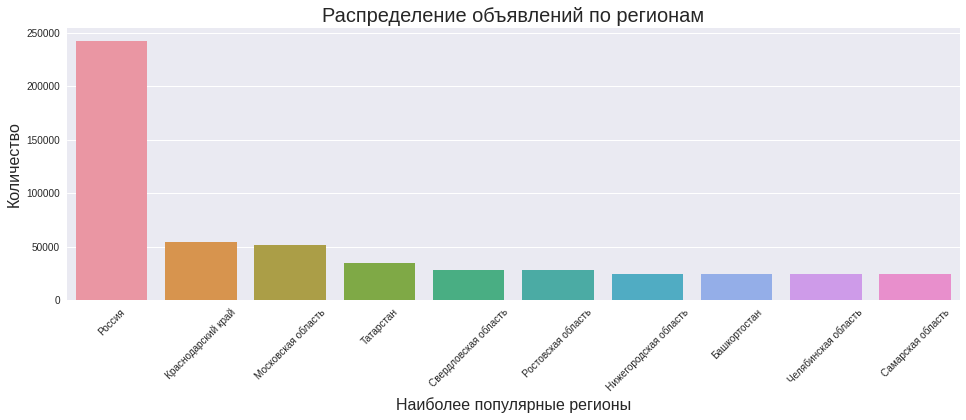

In [33]:
plt.figure(figsize=(16,5))

ax = sns.barplot(x=data.index, y=data.values)
ax.set_xlabel('Наиболее популярные регионы', fontsize=16)
ax.set_ylabel('Количество', fontsize=16)
ax.set_title('Распределение объявлений по регионам', fontsize=20)
plt.xticks(rotation=45)

#### __Город__

In [34]:
df_train['city'].value_counts()

Москва             161395
Санкт-Петербург     80604
Краснодар           24273
Казань              20526
Екатеринбург        19453
                    ...  
Ак-Довурак              1
Талицы                  1
Глотовка                1
Смирных                 1
Шахтерск                1
Name: city, Length: 3311, dtype: int64

In [35]:
data = df_train['city'].value_counts().iloc[:10]
data

Москва             161395
Санкт-Петербург     80604
Краснодар           24273
Казань              20526
Екатеринбург        19453
Новосибирск         18617
Нижний Новгород     17822
Ростов-на-Дону      16403
Уфа                 15314
Челябинск           14727
Name: city, dtype: int64

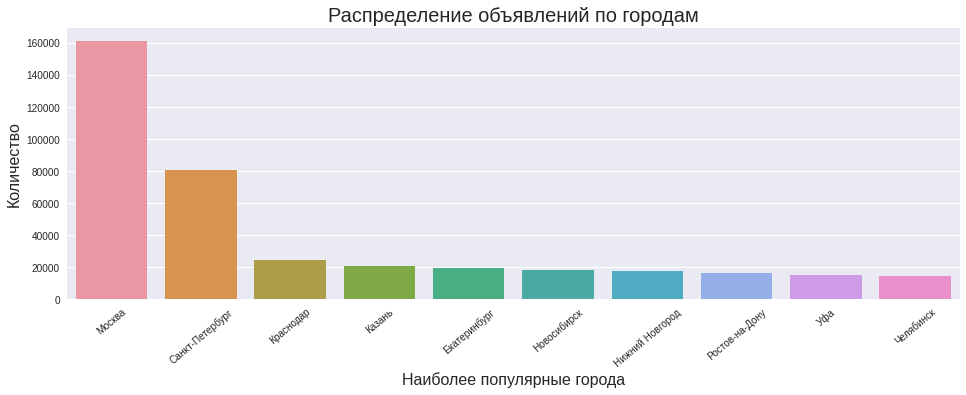

In [36]:
plt.figure(figsize=(16,5))

ax = sns.barplot(x=data.index, y=data.values)
ax.set_xlabel('Наиболее популярные города', fontsize=16)
ax.set_ylabel('Количество', fontsize=16)
ax.set_title('Распределение объявлений по городам', fontsize=20)
plt.xticks(rotation=40);

**Примечание:**  
Интересно, что по частоте Краснодарский край опережает Московскую и Ленинградскую. Но по городам Москва и Санкт-Петербург лидируют.

#### __Категории и подкатегории__

In [37]:
df_train.groupby(['category', 'subcategory']).count()['is_bad']

category             subcategory                 
Бытовая электроника  Аудио и видео                    24579
                     Игры, приставки и программы       5603
                     Настольные компьютеры             6674
                     Ноутбуки                          7083
                     Оргтехника и расходники           7134
                     Планшеты и электронные книги      4026
                     Телефоны                         66064
                     Товары для компьютера            28310
                     Фототехника                       5447
Для бизнеса          Готовый бизнес                    2035
                     Оборудование для бизнеса         10212
Для дома и дачи      Бытовая техника                  22796
                     Мебель и интерьер                45406
                     Посуда и товары для кухни         5138
                     Продукты питания                  4680
                     Растения                     

In [38]:
data = df_train['category'].value_counts().iloc[:10]
data

Транспорт              214718
Личные вещи            201420
Бытовая электроника    154920
Для дома и дачи        134038
Недвижимость           102553
Хобби и отдых           65092
Услуги                  57353
Животные                31631
Работа                  26752
Для бизнеса             12247
Name: category, dtype: int64

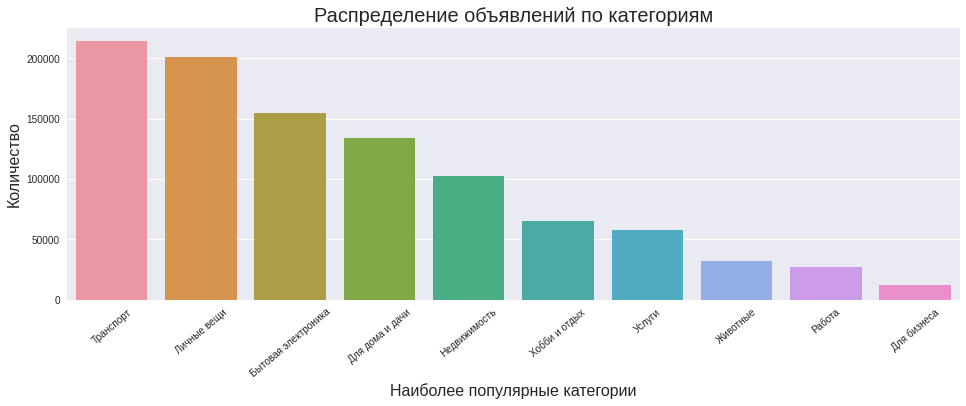

In [39]:
plt.figure(figsize=(16,5))

ax = sns.barplot(x=data.index, y=data.values)
ax.set_xlabel('Наиболее популярные категории', fontsize=16)
ax.set_ylabel('Количество', fontsize=16)
ax.set_title('Распределение объявлений по категориям', fontsize=20)
plt.xticks(rotation=40);

In [40]:
data = df_train['subcategory'].value_counts().iloc[:10]
data

Запчасти и аксессуары         142635
Одежда, обувь, аксессуары      79748
Телефоны                       66064
Детская одежда и обувь         60990
Предложение услуг              57353
Квартиры                       53944
Ремонт и строительство         51630
Автомобили                     45586
Мебель и интерьер              45406
Товары для детей и игрушки     39874
Name: subcategory, dtype: int64

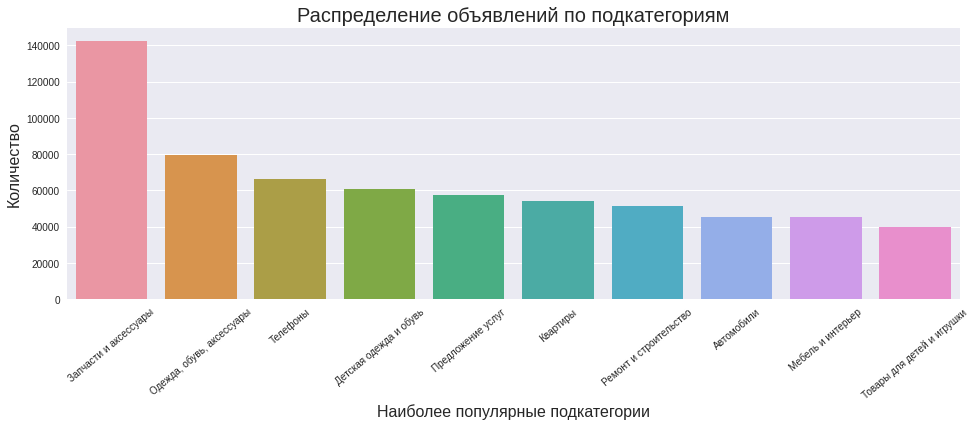

In [41]:
plt.figure(figsize=(16,5))

ax = sns.barplot(x=data.index, y=data.values)
ax.set_xlabel('Наиболее популярные подкатегории', fontsize=16)
ax.set_ylabel('Количество', fontsize=16)
ax.set_title('Распределение объявлений по подкатегориям', fontsize=20)
plt.xticks(rotation=40);

####  __Дата размещения__

In [42]:
# год один - 2019, поэтому его не учитываем
df_train['month'] = pd.to_datetime(df_train['datetime_submitted']).dt.strftime("%m").astype(int)
df_train['day'] = pd.to_datetime(df_train['datetime_submitted']).dt.strftime("%d").astype(int)

In [43]:
df_train = df_train.drop(['datetime_submitted'], axis=1)
df_train.sample(10)

,title,description,subcategory,category,price,region,city,is_bad,month,day
458753,SAMSUNG Galaxy S60,Samsung Galaxy S50/\n/\nВам салютует сеть мага...,Телефоны,Бытовая электроника,47899.0,Татарстан,Казань,0,8,3
108739,Холодильный шкаф,Холодильный шкаф шх 0.5 с/\n /\n Габариты Высо...,Оборудование для бизнеса,Для бизнеса,14000.0,Свердловская область,Екатеринбург,0,6,14
836560,"Skoda Rapid, 2031",Преимущества автомобиля:/\n - 4 хозяина/\n - О...,Автомобили,Транспорт,600000.0,Архангельская область,Архангельск,0,9,21
674599,VIP продленка для младших школьников (центр),"""Умный клуб"" ведет набор школьников 1-4 классо...",Предложение услуг,Услуги,8500.0,Алтайский край,Барнаул,0,8,30
387485,Профнастил некондиция,Наша компания работает более 50 лет!/\n Напрям...,Ремонт и строительство,Для дома и дачи,141.0,Московская область,Мытищи,0,7,23
735215,Микроволновая печь Ariston Hotpoint,Продаю совершенно новую микроволновую печь. По...,Бытовая техника,Для дома и дачи,6990.0,Свердловская область,Екатеринбург,0,9,7
215403,"Chery Fora (A14), 1009",Экономичный двигатель/\n Дешевый в эксплуатаци...,Автомобили,Транспорт,60000.0,Россия,Санкт-Петербург,0,6,29
592682,Сандали антивальгус,Сандали носили 30дней на море. покупали специа...,Детская одежда и обувь,Личные вещи,1000.0,Россия,Москва,0,8,20
744188,Стиральная машина,"Рабочая, нормальная машинка. Звонить по номеру...",Бытовая техника,Для дома и дачи,5000.0,Крым,Севастополь,1,9,8
78228,Электропроводка (Nissan Patrol),[арт. 604827] Электропроводка/\n/\nповреждена/...,Запчасти и аксессуары,Транспорт,4499.0,Кировская область,Киров,0,6,10


####  __Месяц__

In [44]:
df_train.groupby(['month', 'day']).count()['is_bad']

month  day
6      1       9434
       2       6724
       3      11669
       4       7933
       5       8446
              ...  
10     10      3857
       11      2896
       12      3669
       13      2312
       14      3503
Name: is_bad, Length: 136, dtype: int64

In [45]:
data = df_train['month'].value_counts().iloc[:]
data

8     238540
9     230465
6     226905
7     216421
10     88393
Name: month, dtype: int64

Text(0.5, 1.0, 'Распределение объявлений по месяцам')

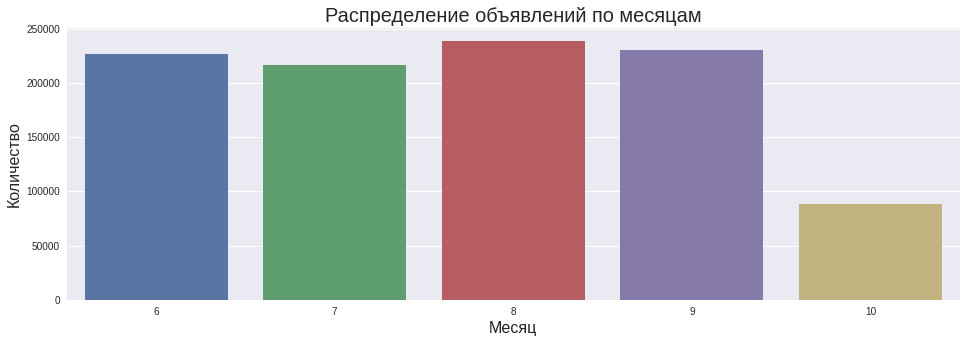

In [46]:
plt.figure(figsize=(16,5))

ax = sns.barplot(x=data.index, y=data.values)
ax.set_xlabel('Месяц', fontsize=16)
ax.set_ylabel('Количество', fontsize=16)
ax.set_title('Распределение объявлений по месяцам', fontsize=20)

**Примечание:**  
Как и везде, пик интенсивности торговли приходится на середину года июнь-сентябрь.

####  __День__

In [47]:
data = df_train['day'].value_counts().iloc[:10]
data

3     44390
5     42610
2     39285
11    38534
4     38231
1     38204
6     38123
7     37690
10    37386
8     36563
Name: day, dtype: int64

Text(0.5, 1.0, 'Распределение объявлений по числам месяца')

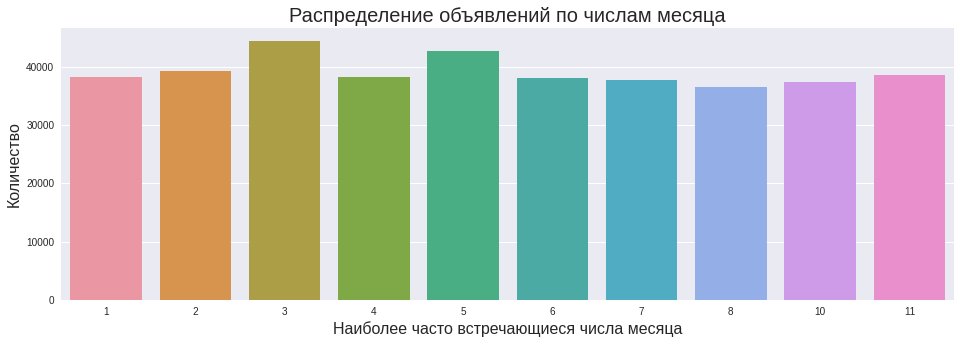

In [48]:
plt.figure(figsize=(16,5))

ax = sns.barplot(x=data.index, y=data.values)
ax.set_xlabel('Наиболее часто встречающиеся числа месяца', fontsize=16)
ax.set_ylabel('Количество', fontsize=16)
ax.set_title('Распределение объявлений по числам месяца', fontsize=20)

####  __Цена__

In [49]:
pd.set_option('display.float_format', lambda x: f'{x:.3f}')

In [50]:
df_train['price'].describe()

count         941813.000
mean        12292473.153
std       2793315614.722
min                0.000
25%             1000.000
50%             3806.000
75%            20000.000
max     999999999999.000
Name: price, dtype: float64

In [51]:
df_train[df_train['price'] > 10000000000]

,title,description,subcategory,category,price,region,city,is_bad,month,day
10807,Бригада фасадчиков,Бригада монтажников НВФ выполнит обустройство ...,Резюме,Работа,89776303121.000,Россия,Москва,1,6,2
24478,Продаю самца недорого,+7 913 188-93-05 звонить сюда,Собаки,Животные,999999999999.000,Волгоградская область,Волгоград,1,6,3
30318,Наращивание Ресниц,Милые девушки ✨👩🏼👩🏻‍🦳👩🏻/\nДля отработки скорос...,Предложение услуг,Услуги,89215728255.000,Россия,Санкт-Петербург,1,6,4
37543,Таунхаус 300 м² на участке 51 сот.,Продам 4-ти квартирный таунхаус незавершенный ...,"Дома, дачи, коттеджи",Недвижимость,89203106443.000,Смоленская область,Смоленск,1,6,5
47700,Дом 30 м² на участке 30 сот.,Общая площадь 443квадрата./\nИмеются:/\n огоро...,"Дома, дачи, коттеджи",Недвижимость,11111000000.000,Ставропольский край,Безопасное,1,6,6
...,...,...,...,...,...,...,...,...,...,...
844708,Продам лп,Продам мою подругу. Зовут Настя( ещё откликает...,Мебель и интерьер,Для дома и дачи,100000000000.000,Саха (Якутия),Нижний Куранах,1,9,22
888963,"2-к квартира, 18.2 м², 5/5 эт.",ПРОДАМ!!!/\nПродам 5х-комнатную квартиру в Хар...,Квартиры,Недвижимость,89143540052.000,Забайкальский край,Шерловая Гора,1,9,28
941783,"Продаются куры,все вопросы по номеру",Продажа Кур,Птицы,Животные,89280871357.000,Чеченская Республика,Алхан-Кала,1,10,4
973855,Ещё один тренер cs:go,"!учу только сильверов, иногда Голд нов и новен...",Предложение услуг,Услуги,999999999999.000,Свердловская область,Екатеринбург,0,10,8


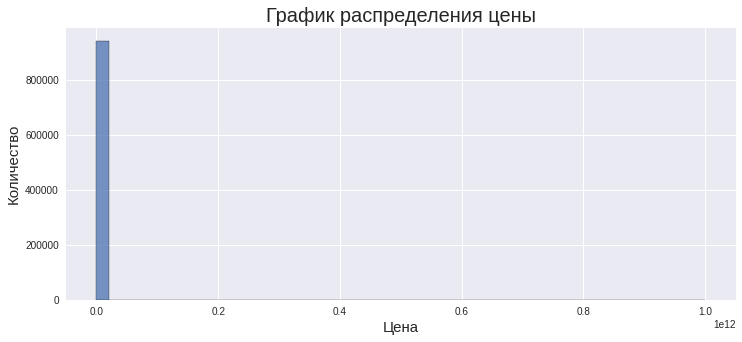

In [52]:
plt.figure(figsize=(12,5))

g = sns.histplot(df_train['price'].dropna(), bins=50)
g.set_xlabel('Цена', fontsize=15)
g.set_ylabel('Количество', fontsize=15)
g.set_title("График распределения цены", fontsize=20);

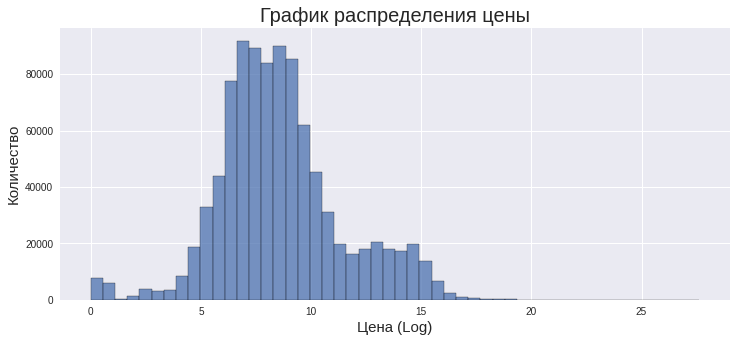

In [53]:
df_train['price_log'] = np.log(df_train['price'] + 1)

plt.figure(figsize=(12,5))

g = sns.histplot(df_train['price_log'].dropna(), bins=50)
g.set_xlabel('Цена (Log)', fontsize=15)
g.set_ylabel('Количество', fontsize=15)
g.set_title("График распределения цены", fontsize=20);

In [54]:
np.exp(5), np.exp(12.5)

(148.4131591025766, 268337.2865208745)

__Выводы:__<br>
В  признаке __price__ присутствуют как заведомо некорректные данные, например номера телефонов, так и явные выбросы. Также, как уже говорилось ранее, есть пропуски: 58048 штук или 5,9%. Как будет видно далее, данный параметр не оказывает сильного влияния на модель, поэтому оставим его как есть.

### Распределение целевой переменной по признакам<a class="anchor" id="target_distribution"></a>

In [55]:
cm = sns.light_palette("blue", as_cmap=True)
pd.crosstab(df_train['category'],
            df_train['is_bad'],
            normalize='index').style.background_gradient(cmap=cm)

is_bad,0,1
category,,
Бытовая электроника,0.863349,0.136651
Для бизнеса,0.855312,0.144688
Для дома и дачи,0.772982,0.227018
Животные,0.454206,0.545794
Личные вещи,0.862496,0.137504
Недвижимость,0.634053,0.365947
Работа,0.603394,0.396606
Транспорт,0.736850,0.263150
Услуги,0.498875,0.501125


In [56]:
cm = sns.light_palette("blue", as_cmap=True)
pd.crosstab(df_train['region'],
            df_train['is_bad'],
            normalize='index').style.background_gradient(cmap=cm)

is_bad,0,1
region,,
Адыгея,0.561798,0.438202
Алтайский край,0.707940,0.292060
Амурская область,0.585584,0.414416
Архангельская область,0.807479,0.192521
Астраханская область,0.669541,0.330459
Башкортостан,0.770570,0.229430
Белгородская область,0.699905,0.300095
Брянская область,0.697555,0.302445
Бурятия,0.592734,0.407266


In [57]:
cm = sns.light_palette("blue", as_cmap=True)
pd.crosstab(df_train['subcategory'],
            df_train['is_bad'],
            normalize='index').style.background_gradient(cmap=cm)

is_bad,0,1
subcategory,,
Автомобили,0.591344,0.408656
Аквариум,0.833711,0.166289
Аудио и видео,0.771716,0.228284
Билеты и путешествия,0.539449,0.460551
Бытовая техника,0.748158,0.251842
Вакансии,0.711257,0.288743
Велосипеды,0.787480,0.212520
Водный транспорт,0.508664,0.491336
Гаражи и машиноместа,0.408251,0.591749


**Вывод**  
Явных взакономерностей не наблюдается

### Определение длины сообщения и % знаков препинания в тексте описания (description)<a class="anchor" id="len_punct"></a>

In [58]:
%%time
# функция для вычисления длины заголовка новости без учета пробелов
df_train['description_len'] = df_train['description'].apply(lambda x: len(x) - x.count(" "))


# функция показывает процент знаков препинания в теле заголовка новости
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

df_train['punct%'] = df_train['description'].apply(lambda x: count_punct(x))


# df_train.head()

CPU times: user 33.5 s, sys: 14.4 ms, total: 33.5 s
Wall time: 33.6 s


In [59]:
data = df_train['description_len'].value_counts().iloc[:10]
data

47    4117
57    4046
53    4045
31    4025
44    4007
49    3996
52    3990
46    3966
45    3966
55    3953
Name: description_len, dtype: int64

Text(0.5, 1.0, 'Распределение объявлений по числу символов')

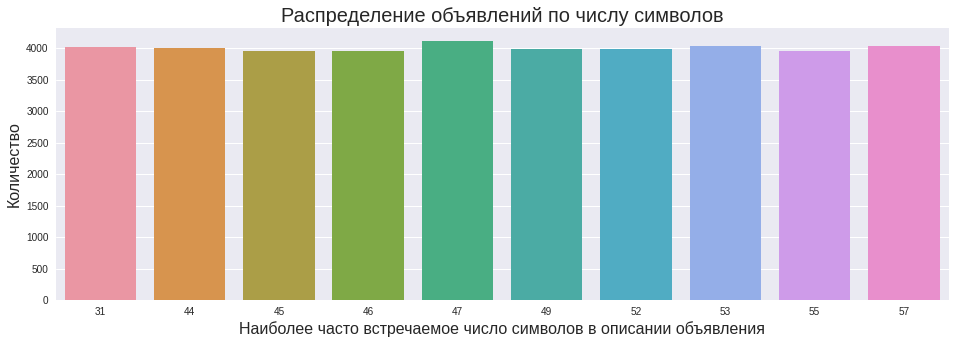

In [60]:
plt.figure(figsize=(16,5))

ax = sns.barplot(x=data.index, y=data.values)
ax.set_xlabel('Наиболее часто встречаемое число символов в описании объявления', fontsize=16)
ax.set_ylabel('Количество', fontsize=16)
ax.set_title('Распределение объявлений по числу символов', fontsize=20)

In [61]:
data = df_train['punct%'].value_counts().iloc[:10]
data

0.000    45917
6.200    16914
5.600    15827
7.100    15217
6.700    15135
5.900    14170
6.100    14078
5.300    14057
6.500    14040
6.800    13817
Name: punct%, dtype: int64

Text(0.5, 1.0, 'Распределение объявлений по проценту пунктуации')

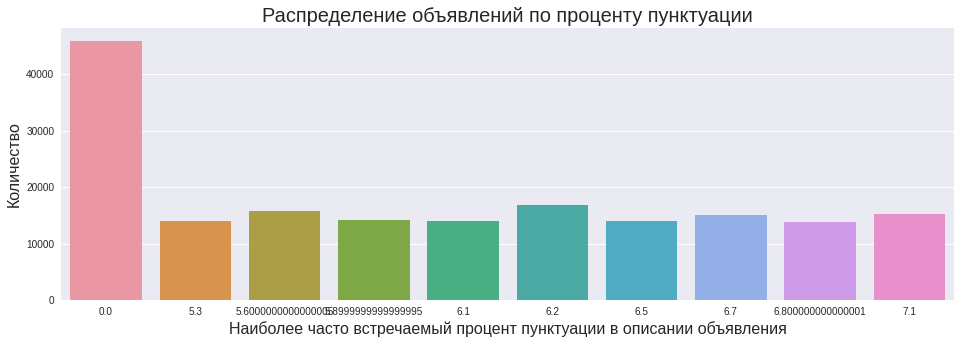

In [62]:
plt.figure(figsize=(16,5))

ax = sns.barplot(x=data.index, y=data.values)
ax.set_xlabel('Наиболее часто встречаемый процент пунктуации в описании объявления', fontsize=16)
ax.set_ylabel('Количество', fontsize=16)
ax.set_title('Распределение объявлений по проценту пунктуации', fontsize=20)

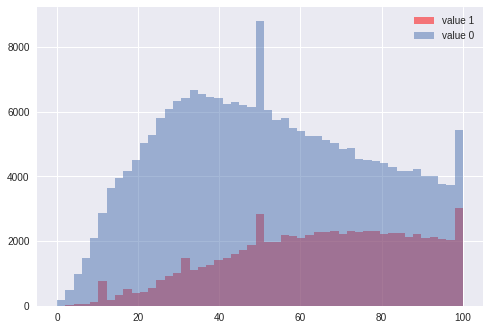

In [63]:
bins = np.linspace(0, 100, 50)

plt.hist(df_train[df_train['is_bad'] == 1]['description_len'], bins, alpha=0.5, label='value 1', color='r')
plt.hist(df_train[df_train['is_bad'] == 0]['description_len'], bins, alpha=0.5, label='value 0')
plt.legend(loc='upper right')
plt.show()

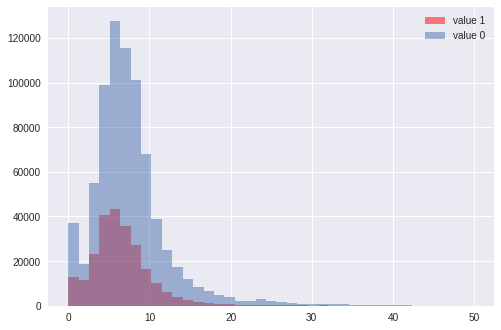

In [64]:
bins = np.linspace(0, 50, 40)

plt.hist(df_train[df_train['is_bad'] == 1]['punct%'], bins, alpha=0.5, label='value 1', color='r')
plt.hist(df_train[df_train['is_bad'] == 0]['punct%'], bins, alpha=0.5, label='value 0')
plt.legend(loc='upper right')
plt.show()

**Вывод:** <br>
Можно сделать вывод, что по длине описания объявления распределены достаточно равномерно, а вот по проценту пунктуации чаще всего встречаются объявления без знаков препинания.<br>
Распределение длины текста и количества знаков препинания в целом повторяют друг друга как в тренировочном, так и в тестовом датасетах.

## Предварительная обработка данных<a class="anchor" id="data_preprocessing"></a> 

#### __Обработка пропусков и выбросов__

В признаке __price__ 58048 (в df_train) значений NaN. В тестовом датасете они тоже присутствуют. Заменим их на среднее значение. Выбросы оставим без внимания.<br>

In [65]:
df_train['price'] = df_train['price'].fillna(df_train['price'].mean())


### Поиск регулярных выражений в описании<a class="anchor" id="regexp_search"></a> 

Производим поиск в описании регулярных выражений. Создаем из результатов поиска датасет

In [66]:
# подгрузка словаря
with open(DICT_PATH) as json_file:
    regexp_dict = json_load(json_file)
    json_file.close()

In [67]:
%%time
search_result = partial(get_dict_search, regexp_dict)
df_train_reg = df_train['description'].parallel_apply(lambda text: search_result(text))

df_train_reg = pd.DataFrame((item for item in df_train_reg), columns = regexp_dict.keys())


CPU times: user 3.82 s, sys: 518 ms, total: 4.34 s
Wall time: 1min 49s


### Очиcтка текста приведение слов к стандартному виду<a class="anchor" id="text_clearing"></a> 

In [68]:
%%time 

df_train['title'] = df_train.title.parallel_apply(get_text_preprocessing)
df_train['description'] = df_train.description.parallel_apply(get_text_preprocessing)
print('df_train OK')

df_train OK
CPU times: user 6.35 s, sys: 1.38 s, total: 7.73 s
Wall time: 3min 27s


Чтобы сократить количество признаков, объединим заголовок и описание

In [69]:
df_train['title_and_description'] = df_train.title + ' ' + df_train.description

df_train.drop(['title', 'description'], axis=1, inplace=True)


Создадим дополнительные признаки, вытащим из 'title_and_description' отдельно текст и цифры

In [70]:
df_train['text'] = df_train.title_and_description.parallel_apply(lambda text: re.sub('[^A-Za-z0-9\.\@\ \-\_]', ' ', text))
df_train['text'] = df_train['text'].parallel_apply(lambda text: re.sub(' +', ' ', text))

df_train['numbers'] = df_train.title_and_description.parallel_apply(lambda text: re.sub('[^0-9\+\(\)\-]', ' ', text))
df_train['numbers'] = df_train['numbers'].parallel_apply(lambda text: re.sub(' +', ' ', text))


Объединим очищенные датасеты с датасетами из регулярных выражений

In [71]:
df_train = pd.concat([df_train, df_train_reg], axis=1)


In [72]:
# Сохраним обработанный вариант датасетов df_train и df_test
df_train.to_csv(PREP_TRAIN_DATASET_PATH, index=False, encoding='utf-8')


## Построение модели CatBoost<a class="anchor" id="modeling"></a> 

In [73]:
%%time

df_train = read_csv(PREP_TRAIN_DATASET_PATH)


y_train = df_train.is_bad


df_train =df_train.drop('is_bad', axis=1)


CPU times: user 11.5 s, sys: 663 ms, total: 12.1 s
Wall time: 12.1 s


In [74]:
feature_names = [
                 'subcategory',
                 'category',
                 # 'price',
                 'region',
                 'city',
                 'month',
                 'day',
                 'price_log',
                 'description_len',
                 # 'punct%',
                 'title_and_description',
                 'text',
                 'numbers',
                 'phone',
                 'email',
                 'youtube',
                 'site',
                 'phone_operators',
                 'messenger'                 
                ]

In [75]:
cat_features =['category', 'subcategory', 'phone', 'email',  'phone_operators', 'messenger','youtube', 'site',]

text_features = ['title_and_description', 'text', 'numbers', 'region', 'city',]

In [76]:
X_train, X_val, y_train, y_val = (train_test_split(df_train, y_train, test_size=0.2, random_state=RANDOM, stratify=df_train['category']))

In [77]:
pool_train = Pool(data=X_train[feature_names], label=y_train, text_features=text_features, cat_features=cat_features) 
pool_val = Pool(data=X_val[feature_names], label=y_val, text_features=text_features, cat_features=cat_features)


Вспомним про дисбаланс классов целевой переменной.  

In [78]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

3.1272277355329297

In [79]:
cat_model = CatBoostClassifier()

In [80]:
# grid_params = {
#     'reg_lambda': [1, 3, 5, 7, 9],
#     'learning_rate': [0.03, 0.1],
#     'depth': [6, 10, 13]
# }

In [81]:
# cv = StratifiedKFold(n_splits=3, random_state=RANDOM, shuffle=True)

In [82]:
# grid_search = cat_model.grid_search(grid_params, 
#                                     pool_train, 
#                                     calc_cv_statistics=True,
#                                     search_by_train_test_split=True,                                    
#                                     cv=cv, 
#                                     stratified=True, 
#                                     plot=True, 
#                                     refit=True)

In [83]:
# cat_model = CatBoostClassifier(**frozen_params, iterations=2000)

# cat_model.fit(
#     pool_train,    
#     eval_set=pool_val,    
#     verbose=500,
#     plot=True
# )

# print(f"Model is fitted: {str(cat_model.is_fitted())}")
# print(f"Model params: {cat_model.get_params()}")
# print('Tree count: ' + str(cat_model.tree_count_))
# print('Best score: ' + str(cat_model.best_score_))

In [84]:
# cat_model.get_feature_importance(pool_val, prettified=True)

In [85]:
# metrics_printer(X_val[feature_names], y_val, cat_model)

###  Построение финальной модели <a class="anchor" id="final_model"></a>

In [86]:
cat_model_tuned = CatBoostClassifier(
    random_seed=RANDOM,
    iterations=1500,
    bagging_temperature=0.0,
    learning_rate=0.1,
    random_strength=7.3,
    depth=13,
    l2_leaf_reg=5.6,
    eval_metric='AUC',
    verbose=500,
    task_type='GPU',
    class_weights=[1, disbalance],
    use_best_model=True
)

In [87]:
%%time
cat_model_tuned.fit(
    pool_train,    
    eval_set=pool_val,    
    verbose=500,
    plot=True
)

print(f"Model is fitted: {str(cat_model_tuned.is_fitted())}")
print(f"Model params: {cat_model_tuned.get_params()}")
print('Tree count: ' + str(cat_model_tuned.tree_count_))
print('Best score: ' + str(cat_model_tuned.best_score_))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9340504	best: 0.9340504 (0)	total: 923ms	remaining: 23m 3s
500:	test: 0.9790612	best: 0.9790612 (500)	total: 6m 54s	remaining: 13m 47s
1000:	test: 0.9802328	best: 0.9802328 (1000)	total: 13m 4s	remaining: 6m 31s
1499:	test: 0.9806238	best: 0.9806241 (1495)	total: 18m 40s	remaining: 0us
bestTest = 0.9806241393
bestIteration = 1495
Shrink model to first 1496 iterations.
Model is fitted: True
Model params: {'iterations': 1500, 'learning_rate': 0.1, 'depth': 13, 'l2_leaf_reg': 5.6, 'random_seed': 42, 'use_best_model': True, 'verbose': 500, 'class_weights': [1, 3.1272277355329297], 'random_strength': 7.3, 'eval_metric': 'AUC', 'bagging_temperature': 0.0, 'task_type': 'GPU'}
Tree count: 1496
Best score: {'learn': {'Logloss': 0.10101702501251589}, 'validation': {'Logloss': 0.1770996765310958, 'AUC': 0.9806241393089294}}
CPU times: user 20min 46s, sys: 13.7 s, total: 21min
Wall time: 19min 39s


Default metric period is 5 because AUC is/are not implemented for GPU  
0:	test: 0.9340504	best: 0.9340504 (0)	total: 903ms	remaining: 22m 33s  
500:	test: 0.9790612	best: 0.9790612 (500)	total: 6m 53s	remaining: 13m 44s  
1000:	test: 0.9801991	best: 0.9801991 (1000)	total: 13m 5s	remaining: 6m 31s  
1499:	test: 0.9806145	best: 0.9806152 (1490)	total: 18m 39s	remaining: 0us 
bestTest = 0.9806151986  
bestIteration = 1490
Shrink model to first 1491 iterations.
Model is fitted: True
Model params: {'iterations': 1500, 'learning_rate': 0.1, 'depth': 13, 'l2_leaf_reg': 5.6, 'random_seed': 42, 'use_best_model': True, 'verbose': 500, 'class_weights': [1, 3.1272277355329297], 'random_strength': 7.3, 'eval_metric': 'AUC', 'bagging_temperature': 0.0, 'task_type': 'GPU'}
Tree count: 1491
Best score: {'learn': {'Logloss': 0.1014165920796121}, 'validation': {'Logloss': 0.17712223710953817, 'AUC': 0.9806151986122131}}
CPU times: user 20min 47s, sys: 12.7 s, total: 21min
Wall time: 19min 39s

0:	test: 0.9343328	best: 0.9343328 (0)	total: 910ms	remaining: 22m 43s  
500:	test: 0.9776342	best: 0.9776342 (500)	total: 6m 50s	remaining: 13m 38s  
1000:	test: 0.9787792	best: 0.9787792 (1000)	total: 12m 44s	remaining: 6m 21s  
1499:	test: 0.9793046	best: 0.9793046 (1499)	total: 18m 30s	remaining: 0us  
bestTest = 0.9793046117  
bestIteration = 1499
Model is fitted: True
Model params: {'iterations': 1500, 'learning_rate': 0.1, 'depth': 13, 'l2_leaf_reg': 5.6, 'random_seed': 42, 'use_best_model': True, 'verbose': 500, 'class_weights': [1, 3.1272277355329297], 'random_strength': 7.3, 'eval_metric': 'AUC', 'bagging_temperature': 1.0, 'task_type': 'GPU'}
Tree count: 1500
Best score: {'learn': {'Logloss': 0.12090222397011394}, 'validation': {'Logloss': 0.18284496195066216, 'AUC': 0.9793046116828918}}
CPU times: user 20min 39s, sys: 18.1 s, total: 20min 57s
Wall time: 19min 37s


0:	test: 0.9335405	best: 0.9335405 (0)	total: 1.14s	remaining: 28m 30s  
500:	test: 0.9772252	best: 0.9772252 (500)	total: 7m 28s	remaining: 14m 55s  
1000:	test: 0.9784591	best: 0.9784591 (1000)	total: 13m 44s	remaining: 6m 51s  
1499:	test: 0.9789559	best: 0.9789585 (1480)	total: 19m 42s	remaining: 0us  
bestTest = 0.9789585471  
bestIteration = 1480  
Shrink model to first 1481 iterations.
Model is fitted: True
Model params: {'iterations': 1500, 'learning_rate': 0.1, 'depth': 13, 'l2_leaf_reg': 5.6, 'random_seed': 42, 'use_best_model': True, 'verbose': 500, 'class_weights': [1, 3.129267263907865], 'random_strength': 7.3, 'eval_metric': 'AUC', 'bagging_temperature': 1.0, 'task_type': 'GPU'}
Tree count: 1481
Best score: {'learn': {'Logloss': 0.12229040484904248}, 'validation': {'Logloss': 0.1843358529986173, 'AUC': 0.9789585471153259}}
CPU times: user 21min 54s, sys: 15.7 s, total: 22min 9s
Wall time: 20min 48s


0:	test: 0.9365174	best: 0.9365174 (0)	total: 969ms	remaining: 24m 12s
500:	test: 0.9762155	best: 0.9762155 (500)	total: 6m 50s	remaining: 13m 38s
1000:	test: 0.9780490	best: 0.9780978 (975)	total: 12m 40s	remaining: 6m 19s
1499:	test: 0.9790312	best: 0.9790348 (1495)	total: 18m 16s	remaining: 0us
bestTest = 0.9790347815
bestIteration = 1495
Shrink model to first 1496 iterations.
Model is fitted: True
Model params: {'iterations': 1500, 'learning_rate': 0.09729575163652356, 'depth': 13, 'l2_leaf_reg': 5.472775259508048, 'use_best_model': True, 'verbose': 500, 'class_weights': [1, 3.1318874187626915], 'random_strength': 7.151011776806903, 'eval_metric': 'AUC', 'bagging_temperature': 0.0, 'task_type': 'GPU'}
Tree count: 1496
Best score: {'learn': {'Logloss': 0.14291975080531932}, 'validation': {'Logloss': 0.1805890066760912, 'AUC': 0.9790347814559937}}
CPU times: user 20min 34s, sys: 15.6 s, total: 20min 49s
Wall time: 19min 28s

In [88]:
cat_model_tuned.get_feature_importance(pool_val, prettified=True)

,Feature Id,Importances
0,title_and_description,38.383
1,phone,14.691
2,text,10.959
3,description_len,8.135
4,numbers,7.491
5,price_log,3.666
6,category,3.328
7,city,3.008
8,region,2.308
9,subcategory,2.301


### Сохранение финальной модели<a class="anchor" id="final_model_saving"></a>

In [89]:
final_model = cat_model_tuned

In [90]:
final_model.save_model(MODEL_FILE_PATH)

In [91]:
# final_model.load_model(MODEL_FILE_PATH)
# print(final_model.get_params())
# print(final_model.random_seed_)

### Сохранение результатов<a class="anchor" id="saving_results"></a>

In [92]:
index = pd.Series(range(0,len(X_val)))
predictions_proba = final_model.predict_proba(pool_val)
df_proba = pd.DataFrame(predictions_proba)

prediction = pd.DataFrame()
prediction['index'] = index
prediction['prediction'] = df_proba[1]

In [93]:
prediction.to_csv(SUBMISSION_PATH, index=False)

In [94]:
pred = read_csv(SUBMISSION_PATH)
pred

,index,prediction
0,0,0.942
1,1,0.201
2,2,0.005
3,3,0.973
4,4,0.988
...,...,...
200140,200140,0.078
200141,200141,0.361
200142,200142,0.269
200143,200143,0.154
